In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
!pip install langchain sentence-transformers faiss-cpu pypdf transformers torch langchain-community

In [125]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoModelForSeq2SeqLM
from langchain.chains import RetrievalQA

# POPRAWKA: Asystent AI - PDF RAG

Po dwóch udanych misjach – rozwikłaniu tajemnicy przeżycia na Titanicu i odczytaniu ręcznych notatek o pokojach – myślałeś, że zasłużysz na odpoczynek. Jednak telefon od tajemniczego zleceniodawcy rozbrzmiał ponownie, tym razem z jeszcze pilniejszą sprawą.

"Wasze poprzednie modele były kluczowe," – rozpoczął głos w słuchawce – "ale to dopiero wstęp do prawdziwego wyzwania. Nasi agenci przechwycili poufny szpont dokumentów. To nie są zwykłe papiery; to zestaw od 3 do 5 artykułów naukowych w formacie PDF, które zawierają fragmenty przełomowych badań. Informacje są niekompletne, celowo pomieszane i zaszyfrowane."

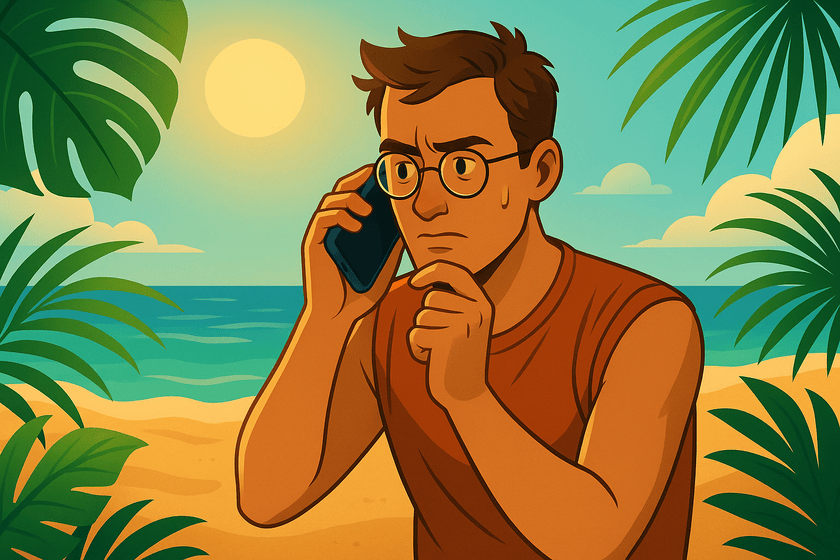

(*AI-generated image*)

Twoim celem będzie stworzenie asystenta RAG - Retrival Augmented Generation na podstawie kilku plików PDF z artykułami naukowymi na wybrany przez siebie temat (3-5 artykułów).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:
- Czy model poprawnie odpowiada na pytania ?
- Jakie są etapy przetwarzania dokumentu tekstowego ?
- Jaki wynik jest "dobry" ?
- Co robi mój asystent AI ? Jak on działa ? Jak tworzona jest odpowiedź ?
- Czy model poprawnie wybiera fragment dokumentu ? Czy poprawnie korzysta z bazy ?
- Jaką rolę w naszym systemie pełni baza wektorowa ?

Wymagania:
- Przygotuj artykuły naukowe i umieść je w folderze na dysku
- Stwórz wektorową bazę danych (można użyć innego systemu niż FAISS)
- Zapełnij bazę embeddingami z modelu wybranego przez Ciebie z [Sentence Similarity Models](https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=trending) z HuggingFace Hub - innego niż podany w notebooku wzorcowym
- Zainicjuj wybrany model QA z dostępnych [Question Answering Models](https://huggingface.co/models?pipeline_tag=question-answering&sort=trending) z HuggingFace Hub - również innego niż w notebooku wzorcowym
- Stwórz chaina odpowiadania na pytania i dodaj mechanizm pętli - tak, żeby można było przeprowadzać swobodną rozmowę z asystentem

**Dodatkowe wymagania**
- Mechanizm pamięci konwersacji - tak, żeby model pamiętał poprzednią część konwersacji
- Mechanizm braku halucynacji (bez cyberpsychozy) - jeśli model nie znajdzie odpowiedzi w bazie, informuje o tym
- Cytowanie dokumentu, z którego model pobrał informacje

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza Markdown.






# Artykuły

Będę bazować na kilku artykułach z Google Scholar na temat AI w biznesie:
- AI Into Business Automation: Practical Frameworks For
Streamlining Operations
- AI startups for good: A taxonomy and archetypes of sustainable business models
- The Competitive Advantage of AI in Business: A
Strategic Imperative
- Navigating the Digital Odyssey: AI-Driven Business Models in Industry 4.0
- Algorithmic bias, data ethics, and governance: Ensuring fairness, transparency and
compliance in AI-powered business analytics applications


Krążą wokół tego samego tematu, ale każdy z nich zawiera troszkę inne spojrzenie na niego - spora baza wiedzy dla modelu.


## Ładowanie i przetwarzanie artykułów

Zgodnie z sugestią użyję biblioteki os.

In [126]:
import os
pdf_path = '/content/drive/MyDrive/NLP_articles' # ścieżka folderu z moimi artykułami

pdf_files = [f for f in os.listdir(pdf_path) if f.endswith('.pdf')] # tutaj wybieramy tylko pliki w formacie .pdf

paths = [os.path.join(pdf_path, f) for f in pdf_files]
loaders = [PyPDFLoader(path) for path in paths]
pages = [loader.load() for loader in loaders]

rows = len(pages)
cols = [len(page) for page in pages]
print(f'Mamy {rows} plików, z tyloma stronami: {cols}')

Mamy 5 plików, z tyloma stronami: [13, 44, 19, 14, 25]


In [127]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=100,
    length_function=len,
    separators=["\n\n", "\n", " ", ""]
)

all_pages = [page for sublist in pages for page in sublist]
docs = text_splitter.split_documents(all_pages)

first_page = 54
for idx,doc in enumerate(docs[first_page:first_page+4]):
  print(f"[Page {idx+first_page}].{doc}\n\n")

[Page 54].page_content='economic. Following this, sustainable business models take into account 
their impacts on people, the planet, and profit ( Kluza et al., 2021 ). Such 
business models position “ sustainability as an integral part of the com -' metadata={'producer': 'Acrobat Distiller 8.1.0 (Windows)', 'creator': 'Elsevier', 'creationdate': '2025-07-17T14:56:21+00:00', 'crossmarkdomains[1]': 'elsevier.com', 'crossmarkmajorversiondate': '2010-04-23', 'creationdate--text': '19th July 2025', 'elsevierwebpdfspecifications': '7.0.1', 'robots': 'noindex', 'moddate': '2025-07-19T05:56:33+00:00', 'author': 'Johanna Paeplow', 'doi': '10.1016/j.jclepro.2025.146144', 'title': 'AI startups for good: A taxonomy and archetypes of sustainable business models', 'keywords': 'Business models,Sustainability,Artificial intelligence,Conceptualization', 'subject': 'Journal of Cleaner Production, 520 (2025) 146144. doi:10.1016/j.jclepro.2025.146144', 'crossmarkdomains[2]': 'sciencedirect.com', 'crossma

# Wektorowa baza danych + embedding

Zgodnie z wymaganiami (cytowanie, brak cyberpsychozy, pamięć zapytań) wybrałam embedding "BAAI/bge-large-en-v1.5". To model, który osiąga topowe wyniki w semantycznym wyszukiwaniu, jest stabilny i dobrze współpracuje z LangChain.

In [128]:
embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    encode_kwargs={"normalize_embeddings": True} # normalizacja
)

Normalizujemy embeddingu, ponieważ większość baz wektorowych — w tym FAISS — używa cosine similarity jako metryki porównania, która działa najlepiej, gdy wektory są znormalizowane. Zmieniłam środowisko wykonawcze z CPU na GPU T4 z collaba - może uda się tym razem bazę z tym embeddingiem stworzyć.


In [129]:
db = FAISS.from_documents(docs, embedding_model)
db.save_local("faiss_index_bge")

UDAŁO SIĘ

Mieliło 11 min.

# Retrieval - podobne fragmenty

In [130]:
db = FAISS.load_local("faiss_index_bge", embedding_model, allow_dangerous_deserialization=True)

query = 'How AI helps in business?'
similar_docs = db.similarity_search(query, k=5)

for doc in similar_docs:
    print('...' + doc.page_content[:300] + "...\n")

...end-to-end, AI contributes to a more efficient sales 
funnel, stronger engagement, and ultimately healthier 
unit economics. 
 
Strategic Insight: 
SaaS companies that treat automation not just as a cost 
reducer, but as a productized revenue lever, are better...

...predictive insights and automation. AI -powered business analytics facilitates real -time decision -making, enhances 
operational efficiency, and optimizes customer interactions. Industries such as finance, healthcare, and retail rely...

...The collaboration between AI and digital business models improves operational effi-
ciency and drives organizations toward a future marked by innovation, adaptability, 
and customer-focused strategy. Adapting to Industry 4.0, which integrates AI and...

...ness model innovations. The implementation of AI technologies aids in fostering 
dynamic and adaptive business strategies, thereby significantly influencing organi-
zational performance (Wamba, 2022). Combining machine learning, b

Klasyczny retrieval poradził sobie naprawdę dobrze, spróbuję teraz z doprecyzowaniem trafności.

In [131]:
results = db.similarity_search_with_score(query, k=10)

for doc, score in results:
    if score < 0.5:
        continue
    print('...' + doc.page_content[:300] + "...\n")

...predictive insights and automation. AI -powered business analytics facilitates real -time decision -making, enhances 
operational efficiency, and optimizes customer interactions. Industries such as finance, healthcare, and retail rely...

...The collaboration between AI and digital business models improves operational effi-
ciency and drives organizations toward a future marked by innovation, adaptability, 
and customer-focused strategy. Adapting to Industry 4.0, which integrates AI and...

...ness model innovations. The implementation of AI technologies aids in fostering 
dynamic and adaptive business strategies, thereby significantly influencing organi-
zational performance (Wamba, 2022). Combining machine learning, big data...

...exists, even though it is technically possible for others to do the same. This limitation makes it hard for 
both academics to understand and managers to act. 
So, learning how to use AI is a strategic must-do that is very important for the future. If c

# Model QA (ekstrakcyjny)

Będę bazować na podstawowym pytaniu we wszystkich modelach:
- 'Jak AI pomaga w biznesie?'

In [132]:
qa_model = pipeline("question-answering", model="deepset/roberta-base-squad2")
response = qa_model(question=query, context=docs[0].page_content)
print(f"Odpowiedź: {response['answer']}")

Device set to use cuda:0


Odpowiedź: sustainable


Cośtam zwróciło, być może jest to sensowna odpowiedź:
- How AI helps in business?
- It makes is sustainable.


## Filtrowanie

Mogę przefiltrować odpowiedzi na dwa sposoby:
- za pomocą similarity_search_with_score: tutaj im mniejszy score tym lepiej (to odległość między wektorem zapytania (query) a dokumentem (treścią odpowiedzi))
- za pomocą score z modelu QA: tutaj jednak im większy score tym lepiej

### Similarity search with score (wstępne filtrowanie)

In [133]:
results = db.similarity_search_with_score(query, k=5)
filtered_docs = [doc for doc, score in results if score < 0.5]
context_0 = " ".join([doc.page_content for doc in filtered_docs])

response = qa_model(question=query, context=context_0)
print(f"Odpowiedź: {response['answer']}")
print(f"Trafność: {response['score']:.2f}")

Odpowiedź: more efficient sales 
funnel, stronger engagement
Trafność: 0.05


Odpowiedź bardziej 'obszerna':
- How AI helps in business?
- It helps by enabling a more efficient sales funnel and a stronger (customer??) engagement.\

Teraz spróbuję użyć pętli, aby przejść po każdym chunku i znaleźć najlepszą odpowiedź.

### QA score

Najlepsza odpowiedź:

In [134]:
best_answer = None
best_score = 0

for idx, doc in enumerate(docs):
    context = doc.page_content
    response = qa_model(question=query, context=context)

    score = response['score']
    answer = response['answer']

    if score > best_score:
        best_answer = answer
        best_score = score

print(f"Odpowiedź: {best_answer}")
print(f"Trafność: {best_score:.2f}")

Odpowiedź: digital business models
Trafność: 0.57


Topowe odpowiedzi:

In [135]:
best_answer = None
best_score = 0
results = []

for idx, doc in enumerate(docs):
    context = doc.page_content
    response = qa_model(question=query, context=context)

    score = response['score']
    answer = response['answer']

    if score > best_score:
        best_answer = answer
        best_score = score

    results.append({
        'answer': answer,
        'score': score
    })

top_k = 5
top_results = sorted(results, key=lambda x: x["score"], reverse=True)[:top_k]

for i, res in enumerate(top_results):
    print(f"Odpowiedź: {res['answer']}")
    print(f"Trafność: {res['score']:.2f}")

Odpowiedź: digital business models
Trafność: 0.57
Odpowiedź: efficiency
Trafność: 0.57
Odpowiedź: integration management
Trafność: 0.53
Odpowiedź: digital business models
Trafność: 0.50
Odpowiedź: establish credibility
Trafność: 0.50


# Model QA (generatywny) - 1

In [136]:
model_name = "MBZUAI/LaMini-Flan-T5-77M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer)
llm = HuggingFacePipeline(pipeline=pipe)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever()
)

response = qa_chain.invoke(query)
print(f'Question: {query}')
print('Answer:', response["result"])

Device set to use cuda:0


Question: How AI helps in business?
Answer: AI-powered business analytics facilitates real-time decision-making, enhances operational efficiency, and optimizes customer interactions.


## Prompt template

In [137]:
from langchain.prompts import PromptTemplate

prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=(
        "Answer the question based on the context below.\n\n"
        "Context:\n{context}\n\n"
        "Question:\n{question}"
    )
)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(),
    chain_type_kwargs={"prompt": prompt}
)

response = qa_chain.invoke(query)
print(f'Question: {query}')
print('Answer:', response["result"])

Question: How AI helps in business?
Answer: AI-powered business analytics facilitates real-time decision-making, enhances operational efficiency, and optimizes customer interactions.


# Model QA (generatywny) - 2

In [138]:
model_name = "allenai/tk-instruct-small-def-pos"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer
    )

llm = HuggingFacePipeline(pipeline=pipe)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever()
)

response = qa_chain.invoke(query)
print(f'Question: {query}')
print('Answer:', response["result"])

Device set to use cuda:0


Question: How AI helps in business?
Answer: AI -powered business analytics improves operational effi- ciency and drives organizations toward a future marked by innovation, adaptability, and customer-focused strategy.


## Prompt template

In [139]:
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=(
        "You are an expert assistant. Use the context below to answer the question accurately and concisely.\n\n"
        "Context:\n{context}\n\n"
        "Question:\n{question}\n\n"
        "Answer:"
    )
)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(),
    chain_type_kwargs={"prompt": prompt}
)

response = qa_chain.invoke(query)
print(f'Question: {query}')
print('Answer:', response["result"])

Question: How AI helps in business?
Answer: AI -powered business analytics facilitates real -time decision -making, enhances operational efficiency, and optimizes customer interactions. Industries such as finance, healthcare, and retail rely on the collaboration between AI and digital business models improves operational effi- ciency and drives organizations toward a future marked by innovation, adaptability, and customer-focused strategy. Adapting to Industry 4.0, which integrates AI and big data. The implementation of AI technologies aids in fostering dynamic and adaptive business strategies, thereby significantly significantly influencing organi- zational performance (Wamba, 2022).


# Model QA z notatnika - 3

In [140]:
model_name = "google/flan-t5-small"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer
)

llm = HuggingFacePipeline(pipeline=pipe)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever()
)

response = qa_chain.invoke(query)
print(f'Question: {query}')
print('Answer:', response["result"])

Device set to use cuda:0


Question: How AI helps in business?
Answer: AI -powered business analytics facilitates real -time decision -making, enhances operational efficiency, and optimizes customer interactions


## Prompt template

In [141]:
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=(
        "You are a helpful assistant. Use the context below to answer the question accurately.\n\n"
        "Context:\n{context}\n\n"
        "Question:\n{question}\n\n"
        "Answer:"
    )
)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(),
    chain_type_kwargs={"prompt": prompt}
)

response = qa_chain.invoke(query)
print(f'Question: {query}')
print('Answer:', response["result"])

Question: How AI helps in business?
Answer: a more efficient sales funnel, stronger engagement, and ultimately healthier unit economics
